# Data Wrangle Final Project

##### Introduction
> The main purpose of this project is to use real world data to wrangle (gather, assess, clean) and then apply analysis with visualizations. The data used was from the Twitter account ‘WeRateDogs’ (@dog_rates) which “rates people's dogs with a humorous comments about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc.” (Project Overview, Udacity). There are three pieces of data that will be gathered, cleaned, and then merged together to make one final DataFrame to analyze. 

In [2]:
# Downloading and importing all the necessary libraries to complete the project.
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import os
import re
import warnings
warnings.simplefilter('ignore')

In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
pd.set_option('display.max_colwidth', -1)

## Gathering the Data

> First table `archive` downloaded from the internet manually and programmatically opened into a pandas DataFrame.

In [4]:
archive = pd.read_csv('../input/twitter-archive-enhanced-2.csv')

> Second table `tweet_count` downloaded programmatically from twitter's API using tweepy, then saved to a JSON file, stored in a dictionary, then loaded into a pandas DataFrame.

In [5]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

In [6]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = archive.tweet_id.values
len(tweet_ids)

2356

In [7]:
# set a function for tweet extraction
# file already created so no need to execute to continue the notebook
def tweet_extraction():
    count = 0
    fails_dict = {}
    start = timer()
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

* Code template above provided by Udacity. 

In [8]:
df_list = []
with open('../input/tweet_json.txt') as file:
    for line in file:
        data = json.loads(line)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        df_list.append({'id_str': id_str,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

In [9]:
tweet_count = pd.DataFrame(df_list, columns = ['id_str', 'retweet_count', 'favorite_count'])

> Third table, programmatically downloaded from the Udacity servers and stored in a folder `image_pred`, then written to local computer and loaded into a pandas DataFrame.

In [10]:
# Downloading the image predictions from the internet
folder_name = 'image_pred'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [11]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [12]:
image_pred = pd.read_csv('../input/image-predictions.tsv', sep='\t')

## Assessing the Data

###### Visual

In [13]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [14]:
archive.text.sample(20)

266     RT @dog_rates: This is Ken. His cheeks are magic. 13/10 (IG: ken_shiba) https://t.co/btzf1zTDeQ                                                        
321     This is Wilson. He's aware that he has something on his face. Waiting for you to get it for him. 12/10 https://t.co/FaeinVjzTZ                         
972     This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af. 12/10 https://t.co/7tlZPrePXd                      
2282    This is Genevieve. She is a golden retriever cocktail mix. Comfortable close to wall. Shows no emotions. 9/10 https://t.co/azEoGqVonH                  
1344    When you wake up from a long nap and have no idea who you are. 12/10 https://t.co/dlF93GLnDc                                                           
1115    This is Aldrick. He looks wise af. Also exceptionally fluffy. Only two legs tho (unfortunate). 11/10 would still hug https://t.co/QwiCVLPMNL           
122     This is Gizmo. His favorite thin

In [15]:
tweet_count.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,8213,37671
1,892177421306343426,6073,32352
2,891815181378084864,4015,24376
3,891689557279858688,8369,40992
4,891327558926688256,9072,39191


In [16]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Quality
#### `archive` Table
* Missing values in columns: __in_reply_to_status_id__, __in_reply_to_user_id__, __retweeted_status_id__, __retweeted_status_user_id__, __retweeted_status_timestamp__, and __expanded_urls__.
* Column name __floofer__ should be spelled __'floof'__

#### `image_pred` Table
* The types of dogs in columns __p1__, __p2__, and __p3__ had some uppercase and lowercase letters. 

#### Tidiness
* The column **text** had multiple variables like a url link, rating, and some tweets represented two dogs. 
* The `tweet_count` and `archive` table should be merged as this is related data.


##### Programmatic

In [17]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

> * **tweet_id** has dtype int64 and should be object
> * **timestamp** should be a datetime64 dtype type as well

In [18]:
doggo = archive.doggo.value_counts()
floofer = archive.floofer.value_counts()
pupper = archive.pupper.value_counts()
puppo = archive.puppo.value_counts()
print(doggo); 
print(floofer); 
print(pupper); 
print(puppo)

None     2259
doggo    97  
Name: doggo, dtype: int64
None       2346
floofer    10  
Name: floofer, dtype: int64
None      2099
pupper    257 
Name: pupper, dtype: int64
None     2326
puppo    30  
Name: puppo, dtype: int64


> * Missing information for the dog stages.

In [19]:
archive.name.value_counts().head(20)

None       745
a          55 
Charlie    12 
Oliver     11 
Cooper     11 
Lucy       11 
Tucker     10 
Lola       10 
Penny      10 
Bo         9  
Winston    9  
Sadie      8  
the        8  
Daisy      7  
Bailey     7  
Toby       7  
an         7  
Buddy      7  
Koda       6  
Jax        6  
Name: name, dtype: int64

> Many missing names from the list under __'None'__, and random names like **'a'** and __'an'__ might be parts of strings that got taken out of context.

In [20]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

> The **source** column looks messy and clutters the table

In [21]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
id_str            2339 non-null object
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


> The column **id_str** should be changed to **tweet_id** so merging tables will be smoother.

In [22]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> The **tweet_id** column should be dtype object instead of int64.

### Assessment Summary

#### Quality
#### `archive` Table
* Missing values in columns: __in_reply_to_status_id__, __in_reply_to_user_id__, __retweeted_status_id__, __retweeted_status_user_id__, __retweeted_status_timestamp__, and __expanded_urls__.
* Column name __floofer__ should be spelled __'floof'__
* **tweet_id** has dtype int64 and should be object
* **timestamp** should be a datetime64 dtype type as well
* Missing information for dog stages.
* Many missing names from the list under __'None'__, and random names like **'a'** and __'an'__ might be parts of strings that got taken out of context.
* Remove from table retweets and replies keepng only original tweets.
* Some tweets had **"\&amp"** combined with **";"** which is the html code to display just the ampersand, so that needs to be cleaned up.

#### `tweet_count` Table
* The column **id_str** should be changed to **tweet_id** so merging tables will be smoother.

#### `image_pred` Table
* The types of dogs in columns **p1**, **p2**, and **p3** had some uppercase and lowercase letters. 
* The **tweet_id** column should be dtype object instead of int64.


#### Tidiness

* The `tweet_count` and `archive` table should be merged as this is added data to the other table.
* The **source** column in `archive` table looks messy and clutters the table.
* All three tables will eventually be merged into one.

## Cleaning the Data

Make copies of each table first before cleaning, as to help reduce catastrophe

In [23]:
# trimmed the names in order to make less wordy when coding
archive_clean = archive.copy()
image_clean = image_pred.copy()
tweet_clean = tweet_count.copy()

> #1 **archive: remove from table retweets and replies keeping only original tweets**

##### Define

Find the retweets and replies using the **retweeted_status_id** and **in_reply_to_status_id** columns and remove from the DataFrame

##### Code

In [24]:
drop_retweet = archive_clean[pd.notnull(archive_clean['retweeted_status_id'])].index
drop_reply = archive_clean[pd.notnull(archive_clean['in_reply_to_status_id'])].index

In [25]:
archive_clean.drop(index=drop_retweet, inplace=True)
archive_clean.drop(index=drop_reply, inplace=True)

##### Test

In [26]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

> #2 **archive: Missing values in columns and unnecessary columns**

##### Define

Remove columns with missing values using `dropna()` method. Also, use the `drop()` method to drop **source** column from table as well

##### Code

In [27]:
archive_clean.dropna(axis='columns',how='any', inplace=True)

In [28]:
archive_clean.drop(columns='source', inplace=True)

##### Test

In [29]:
archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,None,None,None


> #3 **Fixing Column Names**

* **tweet_clean: unifying column names**
* **archive_clean: column names**

##### Define

* In the `tweet_clean` table the column name **id_str** changed to **tweet_id** using the `rename()` function.
* In the `archive_clean` table, column name **floofer** should be **"floof"** to match the dog stage associated with it using the `rename()` function. The columns **rating_numerator** and **rating_denominator** should be shortend to **"rate_num"** and **"rate_denom"** to make it less wordy.

##### Code

In [30]:
tweet_clean.rename(index=str, columns={"id_str": "tweet_id"}, inplace=True)
archive_clean.rename(columns={"floofer": "floof", 
                                         "rating_numerator": "rate_num",
                                         "rating_denominator": "rate_denom"}, inplace=True)

##### Test

In [31]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null object
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.1+ KB


In [32]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id      2097 non-null int64
timestamp     2097 non-null object
text          2097 non-null object
rate_num      2097 non-null int64
rate_denom    2097 non-null int64
name          2097 non-null object
doggo         2097 non-null object
floof         2097 non-null object
pupper        2097 non-null object
puppo         2097 non-null object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


> #4 **Fixing Datatypes**

> * **image_clean: tweet_id dtype "string"**
> * **archive_clean: timestamp dtype "datetime"**
> * **archive_clean: tweet_id dtype "string"**

##### Define

* In the `image_clean` table, change the dtype of column **tweet_id** from int64 to object using the `astype()` function. 
* In the `archive_clean` table, change the dtype of column **timestamp** from object to datetime using pandas `to_datetime()` function. 
* In the `archive_clean` table, change the dtype of column **tweet_id** from int64 to object using the `astype()` function.

##### Code

In [33]:
image_clean['tweet_id'] = image_clean['tweet_id'].astype('str')
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype('str')

##### Test

In [34]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [35]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id      2097 non-null object
timestamp     2097 non-null datetime64[ns]
text          2097 non-null object
rate_num      2097 non-null int64
rate_denom    2097 non-null int64
name          2097 non-null object
doggo         2097 non-null object
floof         2097 non-null object
pupper        2097 non-null object
puppo         2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 180.2+ KB


> #5 **image_clean: dog breeds uniformity**

##### Define

In the `image_clean` table, the dogbreeds in the **p1**, **p2**, _and_ **p3** are converting all the names to lowercase letters.

##### Code

In [36]:
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

##### Test

In [37]:
image_clean.p1.head()

0    welsh_springer_spaniel
1    redbone               
2    german_shepherd       
3    rhodesian_ridgeback   
4    miniature_pinscher    
Name: p1, dtype: object

In [38]:
image_clean.p2.head()

0    collie            
1    miniature_pinscher
2    malinois          
3    redbone           
4    rottweiler        
Name: p2, dtype: object

In [39]:
image_clean.p3.head()

0    shetland_sheepdog  
1    rhodesian_ridgeback
2    bloodhound         
3    miniature_pinscher 
4    doberman           
Name: p3, dtype: object

> #6 **archive_clean: clean up text column**

##### Define

* In the `archive_clean` table, change the html ampersand code from **"&amp ;"** to **"&"** in the **text** column
* Remove the **"/n "** the newline symbol 
* Remove ending url link.

##### Code

In [40]:
archive_clean['text'] = archive_clean.text.str.replace("&amp;", "&")
archive_clean['text'] = archive_clean.text.str.replace("\n", " ")
archive_clean['text'] = archive_clean.text.str.replace(r"http\S+", "")
archive_clean['text'] = archive_clean.text.str.strip()

##### Test

In [41]:
archive_clean.query("text == '&amp;'")

,tweet_id,timestamp,text,rate_num,rate_denom,name,doggo,floof,pupper,puppo


In [42]:
archive_clean.iloc[[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10,None
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10,Bookstore
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11,None
1165,Happy 4/20 from the squad! 13/10 for all,4,20,None
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50,Bluebert
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 & 8/10 get it together Flurp,10,10,Travis
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10,Socks
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10,None
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random & can't bark for shit. 10/10 & 5/10,10,10,Oliviér
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 & 10/10 for heartbroken pup,5,10,None


> #7 **archive_clean: fix some of the ratings columns**

##### Define

In the `archive_clean` table, use several methods such as `extractall()`, `query()`, `contains()`, etc to check for misextraction of the ratings.

##### Code

In [43]:
archive_clean.reset_index(inplace=True, drop=True)

In [44]:
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rate_num']]

,text,rate_num
41,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26


In [45]:
hyphen_table = archive_clean.text.str.extractall(r"(\d+\d*\/\d+)")
hyphen_table.head(10)

,,0
,match,
0,0,13/10
1,0,13/10
2,0,12/10
3,0,13/10
4,0,12/10
5,0,13/10
6,0,13/10
7,0,13/10
8,0,13/10


In [46]:
match_1 = hyphen_table.query("match == 1")
match_1.head()

,,0
,match,
588,1,11/10
797,1,7/10
853,1,14/10
948,1,13/10
985,1,11/10


In [47]:
match_1.index.labels

FrozenList([[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [48]:
# copied indices from above
archive_clean.iloc[[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
588,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10,None
797,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10,Bookstore
853,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11,None
948,Happy 4/20 from the squad! 13/10 for all,4,20,None
985,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50,Bluebert
1005,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 & 8/10 get it together Flurp,10,10,Travis
1136,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10,Socks
1234,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10,None
1239,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random & can't bark for shit. 10/10 & 5/10,10,10,Oliviér
1278,When bae says they can't go out but you see them with someone else that same night. 5/10 & 10/10 for heartbroken pup,5,10,None


In [49]:
#rating confused with 9/11(September 11th)
archive_clean.iloc[853, 3] = 14
archive_clean.iloc[853, 4] = 10

#rating confused with 4/20(Weed Day)
archive_clean.iloc[948, 3] = 13
archive_clean.iloc[948, 4] = 10

#rating confused with phrase 50/50 split
archive_clean.iloc[985, 3] = 11
archive_clean.iloc[985, 4] = 10

#rating confused with 7/11 which is name of convience store
archive_clean.iloc[1426, 3] = 10
archive_clean.iloc[1426, 4] = 10

#rating confused with 1/2 representing "half"
archive_clean.iloc[2076, 3] = 9
archive_clean.iloc[2076, 4] = 10

In [50]:
doubles_list = archive_clean.iloc[[588, 797, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047]]
double_index = doubles_list.index

In [51]:
archive_clean.iloc[[41, 528, 586, 1474], [2,3,4]]

,text,rate_num,rate_denom
41,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5,10
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10


In [52]:
archive_clean.iloc[41, 3] = 13.5
archive_clean.iloc[528, 3] = 9.75
archive_clean.iloc[586, 3] = 11.27
archive_clean.iloc[1474, 3] = 11.26

##### Test

In [53]:
archive_clean.iloc[[45, 528, 586, 1474], [2,3,4]]

,text,rate_num,rate_denom
45,This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl,12.00,10
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10


In [54]:
archive_clean.iloc[[853, 948, 985, 1426, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
853,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",14.0,10,None
948,Happy 4/20 from the squad! 13/10 for all,13.0,10,None
985,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,11.0,10,Bluebert
1426,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,10.0,10,Darrel
2076,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,9.0,10,an


> #8 **archive_clean: removing. doubles**

##### Define

* In the `archive_clean` table, there are some tweets with two dogs being rated, therefore those will be dropped because it violates the rules of tidiness. 

##### Code

In [55]:
doubles_list = archive_clean.iloc[[588, 797, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047]]
double_index = doubles_list.index

In [56]:
archive_clean.drop(axis='index', index=double_index, inplace=True)

##### Test

In [57]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 10 columns):
tweet_id      2075 non-null object
timestamp     2075 non-null datetime64[ns]
text          2075 non-null object
rate_num      2075 non-null float64
rate_denom    2075 non-null int64
name          2075 non-null object
doggo         2075 non-null object
floof         2075 non-null object
pupper        2075 non-null object
puppo         2075 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 178.3+ KB


> #9 **MERGE**

##### Define

Take both the `archive_clean` and `tweet_clean` tables and merge into one table using the `join()` method on the columns **tweet_id**.

##### Code

In [58]:
df_merge1 = archive_clean.join(tweet_clean.set_index('tweet_id'), on='tweet_id')

##### Test

In [59]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id          2075 non-null object
timestamp         2075 non-null datetime64[ns]
text              2075 non-null object
rate_num          2075 non-null float64
rate_denom        2075 non-null int64
name              2075 non-null object
doggo             2075 non-null object
floof             2075 non-null object
pupper            2075 non-null object
puppo             2075 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 210.7+ KB


> #10 **Final Merge**

##### Define

Take the newly `df_merge1` table and combine with the `image_clean` table using the same `join()` method on the **tweet_id** column.

##### Code

In [60]:
master = df_merge1.join(image_clean.set_index('tweet_id'), on='tweet_id')

##### Test

In [61]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 23 columns):
tweet_id          2075 non-null object
timestamp         2075 non-null datetime64[ns]
text              2075 non-null object
rate_num          2075 non-null float64
rate_denom        2075 non-null int64
name              2075 non-null object
doggo             2075 non-null object
floof             2075 non-null object
pupper            2075 non-null object
puppo             2075 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
jpg_url           1949 non-null object
img_num           1949 non-null float64
p1                1949 non-null object
p1_conf           1949 non-null float64
p1_dog            1949 non-null object
p2                1949 non-null object
p2_conf           1949 non-null float64
p2_dog            1949 non-null object
p3                1949 non-null object
p3_conf           1949 non-null float64
p3_dog            194

> **Missing Data**

##### Define

Removing the missing rows from the merged tables using the `drop()` method.

##### Code

In [62]:
master_copy = master.copy()

In [63]:
drop_index = master_copy[pd.isnull(master_copy['jpg_url'])].index
drop_index2 = master_copy[pd.isnull(master_copy['retweet_count'])].index
drop_index, drop_index2

(Int64Index([  32,   38,   65,   73,   78,   95,  113,  153,  155,  193,
             ...
             1505, 1512, 1522, 1537, 1552, 1568, 1579, 1594, 1666, 1956],
            dtype='int64', length=126),
 Int64Index([90, 727, 1488], dtype='int64'))

In [64]:
master_copy.drop(index=drop_index, inplace=True)
master_copy.drop(index=drop_index2, inplace=True)

##### Test

In [65]:
master_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 2096
Data columns (total 23 columns):
tweet_id          1946 non-null object
timestamp         1946 non-null datetime64[ns]
text              1946 non-null object
rate_num          1946 non-null float64
rate_denom        1946 non-null int64
name              1946 non-null object
doggo             1946 non-null object
floof             1946 non-null object
pupper            1946 non-null object
puppo             1946 non-null object
retweet_count     1946 non-null float64
favorite_count    1946 non-null float64
jpg_url           1946 non-null object
img_num           1946 non-null float64
p1                1946 non-null object
p1_conf           1946 non-null float64
p1_dog            1946 non-null object
p2                1946 non-null object
p2_conf           1946 non-null float64
p2_dog            1946 non-null object
p3                1946 non-null object
p3_conf           1946 non-null float64
p3_dog            194

In [66]:
master_copy.to_csv(path_or_buf='master.csv', index=False)

In [67]:
master_clean = master_copy[['timestamp','tweet_id', 'rate_num', 'rate_denom', 
                            'name', 'retweet_count', 'favorite_count', 'p1', 'p2', 'p3']]

## Analyzing the Data

> Now we wanna take the final DataFrame and set the index to the **timestamp** column in order to gather some time series analysis. Twitter data is very time specific and would be nice visually to see changes over time. 

In [68]:
#setting the DataFrame to index the timestamp column
master_copy = master_copy.set_index('timestamp')

In [69]:
master_copy.sample(5)

,tweet_id,text,rate_num,rate_denom,name,doggo,floof,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
timestamp,,,,,,,,,,,,,,,,,,,,,,
2015-12-08 00:37:11,674024893172875264,When you realize it doesn't matter how hard you study. You're still going to fail. 10/10,10.0,10,None,None,None,None,None,1255.0,1798.0,https://pbs.twimg.com/media/CVqeEKLW4AA1wXH.jpg,1.0,pomeranian,0.648500,True,pekinese,0.339835,True,persian_cat,0.006448,False
2016-01-11 03:17:53,686386521809772549,Say hello to Crimson. He's a Speckled Winnebago. Main passions are air hockey & parkour. 11/10 would pet thoroughly,11.0,10,Crimson,None,None,None,None,928.0,3385.0,https://pbs.twimg.com/media/CYaI5aaW8AE8Uyk.jpg,1.0,yorkshire_terrier,0.477704,True,silky_terrier,0.171673,True,australian_terrier,0.088334,True
2016-01-27 18:42:06,692417313023332352,Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet,7.0,10,Herschel,None,None,pupper,None,3663.0,9687.0,https://pbs.twimg.com/media/CZv13u5WYAA6wQe.jpg,1.0,bison,0.208922,False,mink,0.169945,False,polecat,0.144494,False
2016-01-31 23:42:03,693942351086120961,This is Kobe. He's a Speckled Rorschach. Requests that someone holds his hand during car rides. 10/10 sick interior,10.0,10,Kobe,None,None,None,None,386.0,1803.0,https://pbs.twimg.com/media/CaFg41YWkAAdOjy.jpg,1.0,groenendael,0.550796,True,norwegian_elkhound,0.154770,True,schipperke,0.080802,True
2015-12-23 17:55:32,679722016581222400,This is Mike. He is a Jordanian Frito Pilates. Frowning because he can't see directly in front of him. 8/10,8.0,10,Mike,None,None,None,None,495.0,1712.0,https://pbs.twimg.com/media/CW7bkW6WQAAksgB.jpg,1.0,boxer,0.459604,True,boston_bull,0.197913,True,french_bulldog,0.087023,True


#### Basic Statistics

In [70]:
# viewing some descriptive statistics with the quantitative measures in our analysis. 
# used round(5) in order to visually see the last two columns without scientific notation involved.
master_copy.describe().round(5)

,rate_num,rate_denom,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1946.00000,1946.00000,1946.00000,1946.00000,1946.00000,1946.00000,1946.00000,1946.00000
mean,12.20698,10.46095,2657.54265,8761.80730,1.20247,0.59385,0.13437,0.06027
std,41.86184,6.83239,4720.33512,12783.37513,0.56104,0.27230,0.10082,0.05095
min,0.00000,7.00000,11.00000,77.00000,1.00000,0.04433,0.00000,0.00000
25%,10.00000,10.00000,590.25000,1919.25000,1.00000,0.36044,0.05299,0.01621
50%,11.00000,10.00000,1291.50000,3967.50000,1.00000,0.58744,0.11740,0.04948
75%,12.00000,10.00000,3020.00000,10921.25000,1.00000,0.84628,0.19536,0.09155
max,1776.00000,170.00000,82760.00000,162648.00000,4.00000,1.00000,0.48801,0.27342


* As shown above, each variable initially seems to follow a logical pattern without abnormal outliers sending red flags. For example, the **rate_denom** the minimum is 2 which makes sense because 0 cannot be the lowest since it's part of a ratio and you cannot divide by zero. 
* Even, though some of the numerators in the **rate_num** column are extraordinarily high and above 10 for the denominator, the rating system for the WeRateDogs feed follows an out of the norm rating system. Therefore, this should not draw attention as an issue. 
* Also, for columns **p1_conf**, **p2_conf**, and **p3_conf**, the numbers are in the bounds from 0 to 1, which is good because they are confidence intervals and are bound between 0 and 1. **p1_conf** has a higher average than **p2_conf** and so forth, and their max and min are higher in both categories respectively. 
* This suggests that the neural network developed to identify the breed of dog works effectively because "p1", "p2" and "p3" are the predictions in succession. Indicating the first prediction (p1) has a higher confidence of being correct than the following predictions. 

#### Correlation

In [71]:
# this method helps to see which variables correlate and helpful when doing a hypothesis test or A/B test. 
master_copy.corr()

,rate_num,rate_denom,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
rate_num,1.000000,0.184969,0.018643,0.016444,-0.002661,-0.006078,-0.020568,-0.007084
rate_denom,0.184969,1.000000,-0.017081,-0.024153,-0.016311,0.012081,-0.038158,-0.006625
retweet_count,0.018643,-0.017081,1.000000,0.929604,0.103987,0.049307,-0.013627,-0.040009
favorite_count,0.016444,-0.024153,0.929604,1.000000,0.129468,0.072529,-0.015030,-0.048673
img_num,-0.002661,-0.016311,0.103987,0.129468,1.000000,0.204418,-0.158178,-0.138856
p1_conf,-0.006078,0.012081,0.049307,0.072529,0.204418,1.000000,-0.509123,-0.706755
p2_conf,-0.020568,-0.038158,-0.013627,-0.015030,-0.158178,-0.509123,1.000000,0.480095
p3_conf,-0.007084,-0.006625,-0.040009,-0.048673,-0.138856,-0.706755,0.480095,1.000000


* The correlation chart is useful for finding connections between variables, especially with hypothesis testing or an A/B test. The numbers range from 0 to 1, and a positive number is a positive correlation and vice versa for a negative number. 
* The correlation coefficient beteen **retweet_count** and **favorite_count** is 0.929604, which is close to 1 and positive demonstrating a strong positive correlation bewteen those two metrics. 
* The only other coefficient worth mentioning is the between **p1_conf** and **p3_conf** which is -0.706755, demonstrating a negative semi-strong relationship. This is probably a result because **p3_conf** confidence score is affected by the results of the first prediction in the neural network. The more confident the result of the first image, the less likely the following images would accurately guess the breed of dog. 

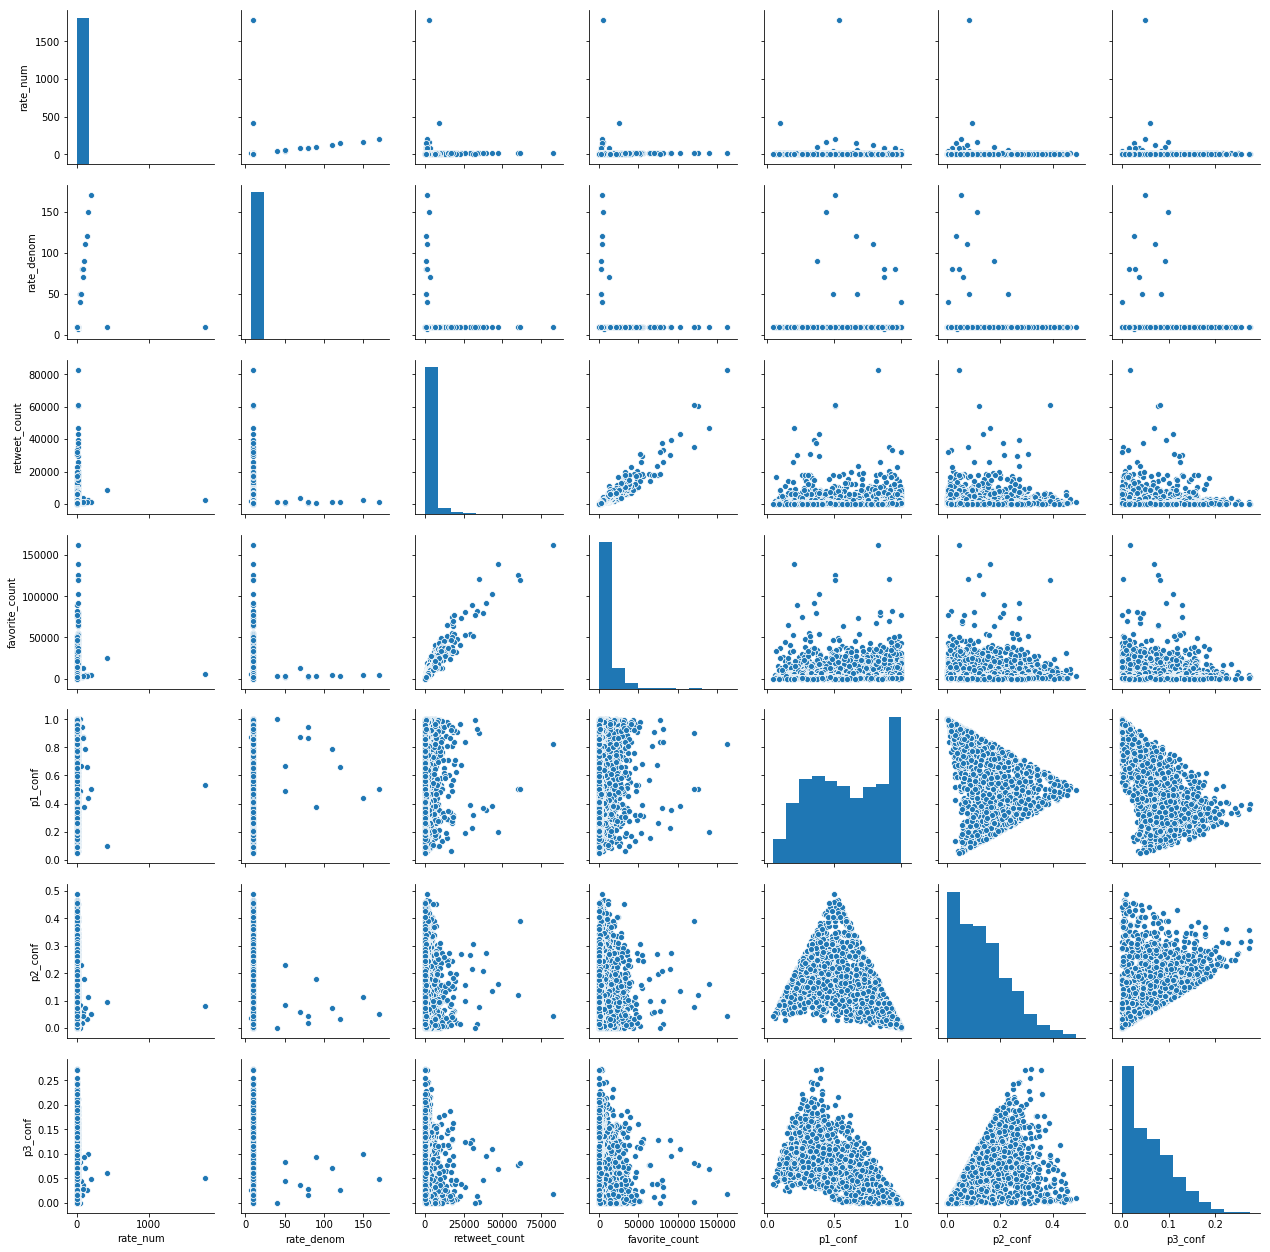

In [72]:
sns.pairplot(master_copy, vars=["rate_num", "rate_denom", "retweet_count", "favorite_count", "p1_conf", "p2_conf", "p3_conf"]);

#### Trends

In [73]:
# set these variables so the plotting code would be cleaner.
retweet_resamp = master_copy['retweet_count'].resample('1w').mean()
favorite_resamp = master_copy['favorite_count'].resample('1w').mean()

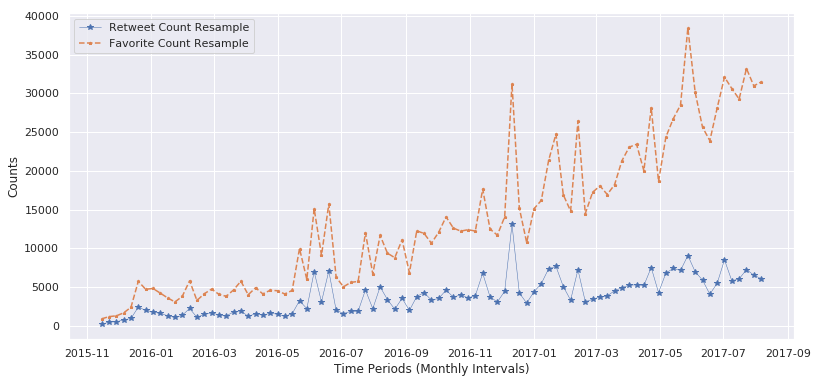

In [74]:
# plotting the resample of weekling favorite and retweet counts to show a smoother display over time.
sns.set(rc={'figure.figsize':(13, 6)})
fig, ax = plt.subplots()
ax.plot(retweet_resamp, marker='*', linestyle='-', linewidth=0.5, label='Retweet Count Resample')
ax.plot(favorite_resamp, marker='*', markersize=3, linestyle='--', label='Favorite Count Resample')
ax.set_ylabel('Counts')
ax.set_xlabel('Time Periods (Monthly Intervals)')
ax.legend();

* The time series code above was modeled after a blog post Tutorial about Time Series Analysis with Pandas. https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

* The line graph above, was used by resampling the average counts of data, in weekly intervals, much like a moving average, which helps smooth out the graph and improve visibility of the trends.
* As mentioned before, with this timeseries chart above, the **favorite_count** and **retweet_count** are positively correlated with one another. This is due to the fact that most people retweet 'tweets' that they like in order for others to see it. It is like 'free advertising' for the 'tweet' itself and shows people on your feed what you're interested in. It's a sharing feature when you want others to see something you've read/seen. 
* According to the chart, there are 3 spikes at specific times of year, those being, the middle of spring into summer, and then the Christmas/Holiday time. This is most likely due to the fact that people with dogs are more active in the warmer months, posting cute things their dog is doing outside. Also, during the holidays, they are more likely to share pics/etc about things they care about during this time i.e. their dogs. 
* The overall trend of the counts shows the popularity of this twitter page slowly growing overtime. If the number of followers were taken into account, it would most likely show a similar trend since the twitter account is getting more "air time." 

## Word Cloud with Tweets

* A word cloud is a fun tool that lets user take the most frequently used words from a text, in this case, the tweets used in the dataset, and display in a fun image. 
* The outline of a paw print was used for this word cloud in association with the @WeRateDogs twitter account that was used in the process of this project.

> First we need to create a list with all the words that were tweeted in our DataFrame.

In [75]:
tweets = np.array(master_copy.text)
my_list = []
for tweet in tweets:
    my_list.append(tweet.replace("\n",""))

> Next, we downloaded an image of a paw print from the internet and used it in the function below to generate a word cloud with the tweets. 

In [76]:
mask = np.array(Image.open(requests.get('https://clipartix.com/wp-content/uploads/2016/06/Dog-bone-pink-print-dog-paw-print-transparent-background-paw-print-pink-clipart.jpg', stream=True).raw))
text = my_list

In [77]:
def gen_wc(text, mask):
    word_cloud = WordCloud(width = 500, height = 500, background_color='white', mask=mask).generate(str(text))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

* The code used above was modeled from this blog on how to generate a word cloud in python.
https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e

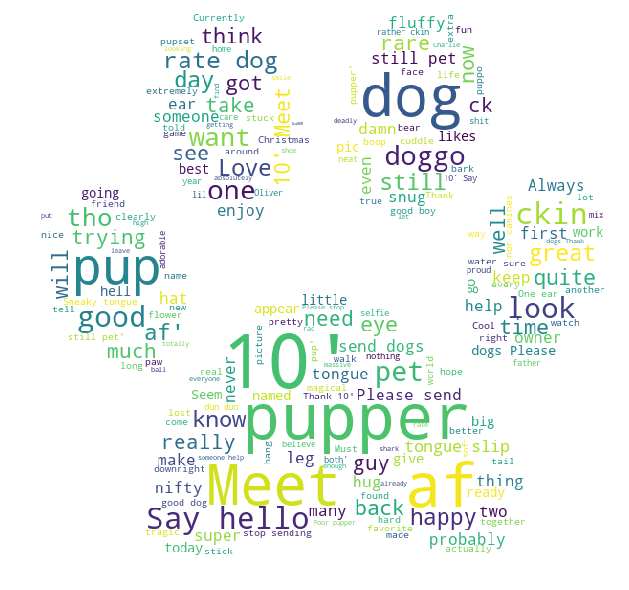

In [78]:
gen_wc(text, mask)